In [ ]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Window Testing

In [5]:
target = 'm'

train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing(target)
validation_cases.process_for_testing(target)
test_cases.process_for_testing(target)

In [6]:
lw, rw = 3, 3
sets = {}
sets['train_set'], sets['train_labels'], sets['train_words'] = train_cases.get_ff_sets(model, left_words=lw, right_words=rw)
sets['validation_set'], sets['validation_labels'], sets['validation_words'] = validation_cases.get_ff_sets(model, left_words=lw, right_words=rw)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model, left_words=lw, right_words=rw)

In [7]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


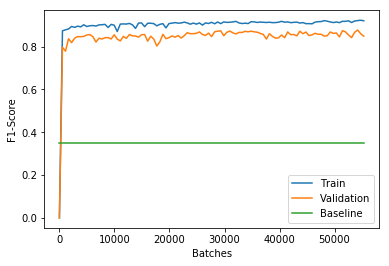

FInal Values: Tr-F1: 0.9207, Val-F1: 0.8489
Test F1-Score: 0.8689



In [8]:
NN = FF_Model(input_size=700, layers=[100])
NN.build_graph()
results_list = NN.train(sets, epochs=10, batch=50, show_progress=True, show_plot=True)

In [9]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [10]:
token_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
477	10540	105	39

Precision: 0.8196
Recall: 0.9244
F1-Score: 0.8689


In [11]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.3458814759597465

In [12]:
fn.category_words(sets['test_words'], res, tru, 0, 1)

by, sliding, intravenous, stents, sliding, subcu, <num>.<num>., drip, drip, medications, qac, qac, sublingual, sublingual, medications, sublingual, expand, their, november, tylenol, insulin, medications, cuboid, hd, sedation, (, antibiotics, drip, drip, <num>mg, panel, <num>mg, aspirin, which, <num>mg, insulin, prandial, drip, drip, current, na, dm, regimen, scale, prostatic, calcium, mg, at, <num>.<num>., control, anticoagulation, meanwhile, d, on, monday-wednesday-friday, regimen, adjusting, qpm, lunch, sliding, flagyl, which, monday-wednesday-friday, monday-wednesday-friday, medication, regimen, for, tablet, wheezing, ran, penicillin, intravenous, contrast, regimen, added, d-dymer, this, instructions, qpm, topical, hcl, huyett, topical, tp, food/drug, iv, ou, aspirin, mon, <num>mg/<num>mg/<num>mg, food/drug, aspirin, motrin, approximate, each, approximate, aspirin, sprays, <num>mg, aspirin, broccoli, d/c, adjusting, ppi, endo


In [13]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [15]:
testers = Dataset.get_DS(stage='train', labelled='yes')
phrase_perf = fn.phrase_perf(target, NN, testers, model, side_words=[lw, rw], case_info=True, show_phrases=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


antibiotics 1 1
axid 2 2
by sliding 1 0
colace 2 2
coumadin 2 2
ecotrin 1 1
heparin 2 3
insulin 0 2
insulin lente 1 1
insulin nph 1 1
insulin subcu 1 0
intravenous heparin 1 0
isordil 2 2
lopressor 2 2
ofloxacin 2 2
percocet 1 1
sliding 1 0
stents 1 0
urokinase 1 1
vancomycin 2 2
zestril 2 2

Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num>.<num>. 1 0
aspirin 1 1
atenolol 1 1
baby aspirin 1 1
beta-blocker 1 1
ciprofloxacin 2 2
epinephrine 1 1
humalog insulin 1 1
insulin 1 1
lantus 1 1
lasix 2 4
lasix drip 2 0
medications 1 0
metformin 1 1
motrin 1 1
nasal cannula 0 1
novolog 2 2
potassium chloride slow release 1 1
precedex 1 1
qac 2 0
toprol-xl 1 1

Name:  0105
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


ace inhibitor 1 1
aspirin 8 8
atenolol 2

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1